Prevendo a qualidade sensorial de um vinho (bom vs ruim) com base nas características físico-químicas e quais variáveis possuem maior influência na predição utilizando KNN sem balanceamento, KNN + Undersampling, KNN + Oversampling e KNN + SMOTE

In [ ]:
%pip install --user scikit-learn imbalanced-learn pandas seaborn matplotlib pyarrow shap

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, precision_recall_curve, recall_score, f1_score, roc_curve, auc, classification_report, ConfusionMatrixDisplay
)
from imblearn.under_sampling import RandomUnderSampler
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_parquet('data/processed/wine-quality.parquet')
print("Colunas do dataset carregado:", df.columns.tolist())

Colunas do dataset carregado: ['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


In [7]:
# Target binária (quality > 5 = bom (1), <=5 ruim (0))
df['good_quality'] = (df['quality'] > 5).astype(int)
df.drop('quality', axis=1, inplace=True)

In [8]:
# Encoding da variável 'type'
if df['type'].dtype == 'object':
    le = LabelEncoder()
    df['type'] = le.fit_transform(df['type'])
    print("Coluna 'type' codificada.")
else:
    print("Coluna 'type' já está numérica.")

Coluna 'type' codificada.



Distribuição das classes (good_quality):
good_quality
1    4113
0    2384
Name: count, dtype: int64


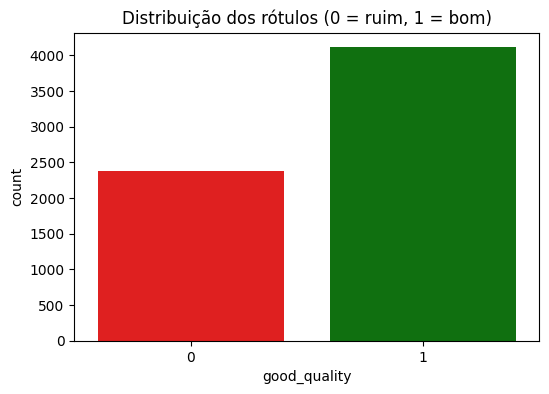

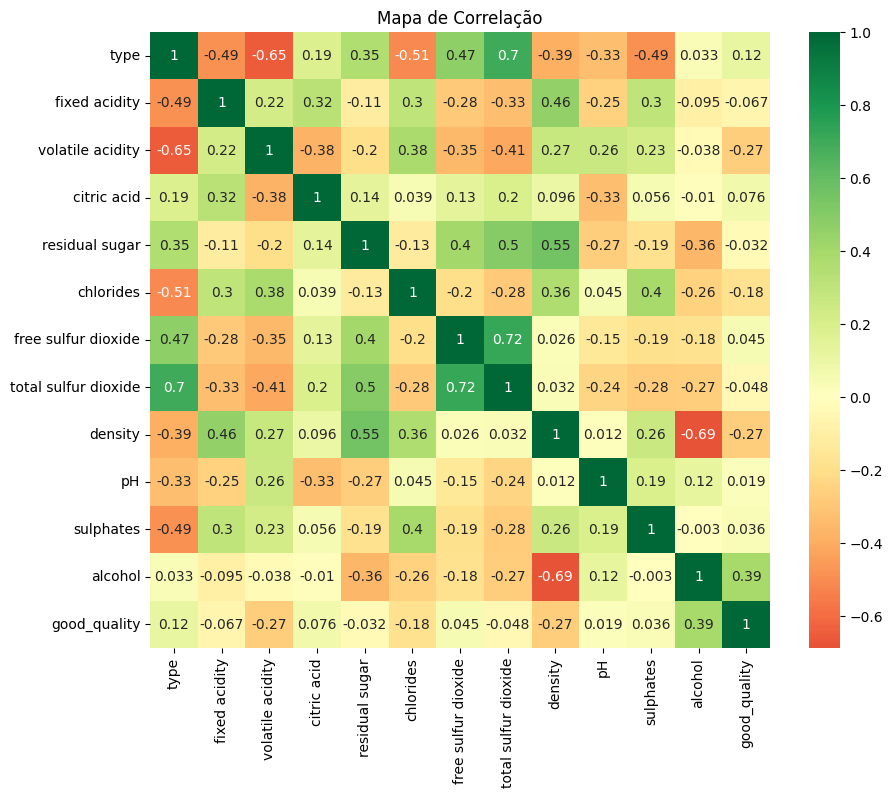

In [9]:
# Análise das classes
print("\nDistribuição das classes (good_quality):")
print(df['good_quality'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='good_quality', hue='good_quality', data=df, palette={0: 'red', 1: 'green'}, legend=False)
plt.title("Distribuição dos rótulos (0 = ruim, 1 = bom)")
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', center=0)
plt.title("Mapa de Correlação")
plt.show()

In [10]:
# X = variáveis independentes (características físico-químicas)
# y = variável dependente (qualidade do vinho)
X = df.drop('good_quality', axis=1)
y = df['good_quality']

In [11]:
# Dividindo treino e teste (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

Seção 0: KNN sem Balanceamento

In [41]:
# Normalização dos dados (fit no treino original)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
# Ajuste de hiperparâmetros com cross-validation
grid.fit(X_train_scaled, y_train)
print("\nMelhores parâmetros encontrados (sem balanceamento):", grid.best_params_)
best_knn_puro = grid.best_estimator_


Melhores parâmetros encontrados (sem balanceamento): {'n_neighbors': 50, 'p': 1, 'weights': 'distance'}


In [43]:
# Avaliação de métricas
tabela_metricas_puro = gerar_tabela_metricas(
    best_knn_puro, X_train_scaled, y_train, X_test_scaled, y_test
)

print("\n===== Tabela de Métricas (KNN Puro - Sem Balanceamento) =====")
print(tabela_metricas_puro)

acc_train_puro = accuracy_score(y_train, best_knn_puro.predict(X_train_scaled))
acc_test_puro = accuracy_score(y_test, best_knn_puro.predict(X_test_scaled))
print(f"\nAcurácia Treino (Puro): {acc_train_puro:.4f}")
print(f"Acurácia Teste (Puro) : {acc_test_puro:.4f}")


===== Tabela de Métricas (KNN Puro - Sem Balanceamento) =====
                Vinhos Ruins Vinhos Bons     Média Média Ponderada
Teste  Precisão     0.815104    0.820961  0.818032        0.818812
       Recall       0.656184     0.91373  0.784957        0.819231
       F1-Score     0.727062    0.864865  0.795963        0.814302
       Suporte         477.0       823.0       NaN             NaN
Treino Precisão          1.0         1.0       1.0             1.0
       Recall            1.0         1.0       1.0             1.0
       F1-Score          1.0         1.0       1.0             1.0
       Suporte        1907.0      3290.0       NaN             NaN

Acurácia Treino (Puro): 1.0000
Acurácia Teste (Puro) : 0.8192


In [44]:
# Cross-validation
cv_scores_puro = cross_val_score(best_knn_puro, X_train_scaled, y_train, cv=5, scoring='accuracy')
cv_mean_puro = cv_scores_puro.mean()
cv_std_puro = cv_scores_puro.std()
print(f"\nCross-Validation Accuracy (Puro): {cv_mean_puro:.4f} ± {cv_std_puro:.4f}")


Cross-Validation Accuracy (Puro): 0.8176 ± 0.0066



Modelo generaliza bem com base na comparação CV vs Teste.


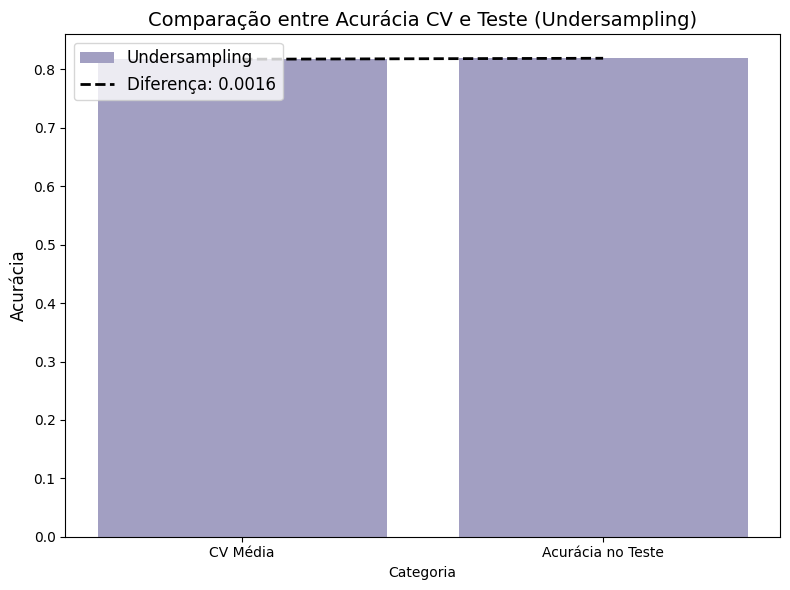

In [51]:
# Verificação de overfitting
diff_puro = abs(cv_mean_puro - acc_test_puro)
limiar = 0.05

if diff_puro > limiar:
    print("\nAtenção: Diferença significativa entre CV (sem balanceamento) e teste.")
    print(f"→ CV Média: {cv_mean_puro:.4f}")
    print(f"→ Teste   : {acc_test_puro:.4f}")
    print(f"→ Diferença: {diff_puro:.4f}")
else:
    print("\nModelo generaliza bem com base na comparação CV vs Teste.")

data_undersampled = pd.DataFrame({
    "Categoria": ["CV Média", "Acurácia no Teste"],
    "Acurácia": [cv_mean_puro, acc_test_puro],
    "Modelo": ["Undersampling"] * 2
})
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x="Categoria", y="Acurácia", data=data_undersampled, ax=ax, palette='Purples', hue="Modelo")
ax.plot([0, 1], [cv_mean_puro, acc_test_puro], 'k--', lw=2, label=f'Diferença: {diff_puro:.4f}')
ax.legend(loc='upper left', fontsize=12)
ax.set_title('Comparação entre Acurácia CV e Teste (Undersampling)', fontsize=14)
ax.set_ylabel('Acurácia', fontsize=12)
plt.tight_layout()
plt.show()

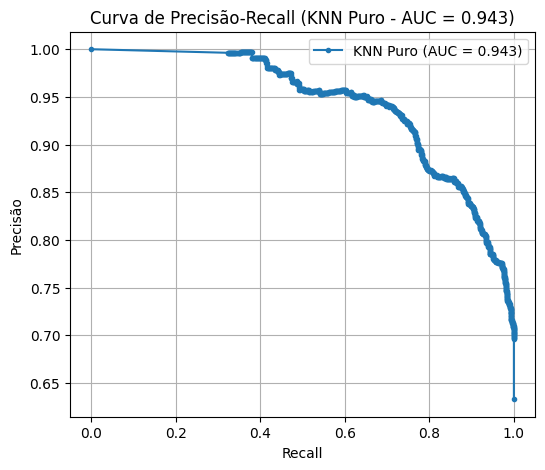

In [46]:
# Curva de Precisão-Recall
precisao_puro, recall_puro, _ = precision_recall_curve(y_test, best_knn_puro.predict_proba(X_test_scaled)[:, 1])
pr_auc_puro = auc(recall_puro, precisao_puro)

plt.figure(figsize=(6, 5))
plt.plot(recall_puro, precisao_puro, marker='.', label=f'KNN Puro (AUC = {pr_auc_puro:.3f})')
plt.title(f'Curva de Precisão-Recall (KNN Puro - AUC = {pr_auc_puro:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.grid(True)
plt.legend()
plt.show()

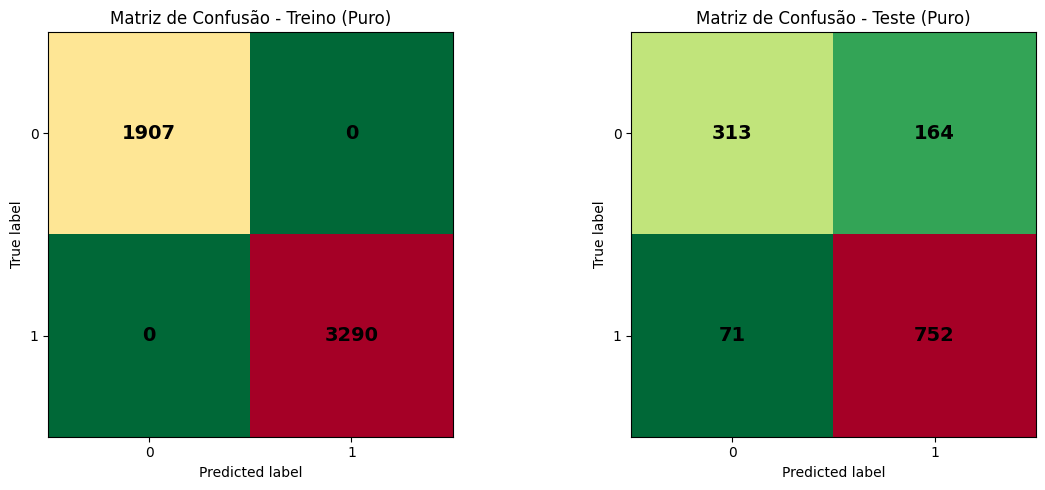

In [47]:
# Matriz de Confusão
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(
    best_knn_puro, X_train_scaled, y_train,
    ax=axes[0],
    cmap='RdYlGn_r',
    colorbar=False
)
axes[0].set_title("Matriz de Confusão - Treino (Puro)")

ConfusionMatrixDisplay.from_estimator(
    best_knn_puro, X_test_scaled, y_test,
    ax=axes[1],
    cmap='RdYlGn_r',
    colorbar=False
)
axes[1].set_title("Matriz de Confusão - Teste (Puro)")
style_confusion_texts(axes[0])
style_confusion_texts(axes[1])
plt.tight_layout()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

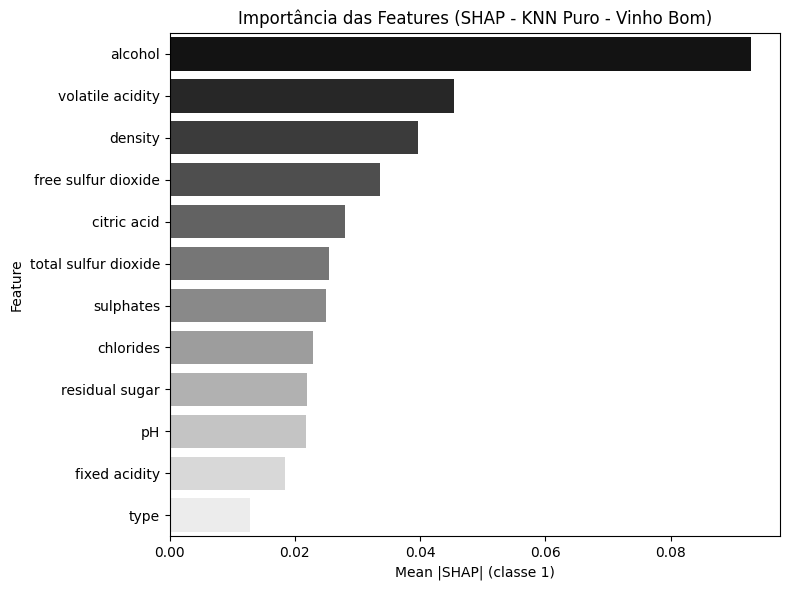


Importância média das características para prever vinhos bons (KNN Puro):
                 Feature  Mean |SHAP| (classe 1)
11               alcohol                0.092824
2       volatile acidity                0.045442
8                density                0.039645
6    free sulfur dioxide                0.033526
3            citric acid                0.027964
7   total sulfur dioxide                0.025422
10             sulphates                0.024967
5              chlorides                0.022877
4         residual sugar                0.021870
9                     pH                0.021774
1          fixed acidity                0.018366
0                   type                0.012766


In [50]:
# SHAP - Importância das Features (Puro)
feature_names = X.columns.tolist()
X_shap_train_puro = pd.DataFrame(X_train_scaled[:100], columns=feature_names)
X_shap_test_puro = pd.DataFrame(X_test_scaled[:50], columns=feature_names)

explainer_puro = shap.KernelExplainer(best_knn_puro.predict_proba, X_shap_train_puro)
shap_values_puro = explainer_puro.shap_values(X_shap_test_puro)

if isinstance(shap_values_puro, list):
    if len(shap_values_puro) > 1:
        shap_values_class1_puro = shap_values_puro[1]
    else:
        shap_values_class1_puro = shap_values_puro[0]
else:
    shap_values_class1_puro = shap_values_puro

if shap_values_class1_puro.ndim == 3:
    shap_values_class1_puro = shap_values_class1_puro[:, :, 1]
elif shap_values_class1_puro.ndim != 2:
    raise ValueError("Formato inesperado nos valores SHAP (puro)")

mean_abs_shap_1_puro = np.abs(shap_values_class1_puro).mean(axis=0).flatten()

feature_importance_puro = pd.DataFrame({
    'Feature': feature_names,
    'Mean |SHAP| (classe 1)': mean_abs_shap_1_puro
}).sort_values(by='Mean |SHAP| (classe 1)', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Mean |SHAP| (classe 1)', y='Feature', data=feature_importance_puro, palette='gray', hue='Feature', legend=False)
plt.title('Importância das Features (SHAP - KNN Puro - Vinho Bom)')
plt.tight_layout()
plt.show()

print("\nImportância média das características para prever vinhos bons (KNN Puro):")
print(feature_importance_puro)

Seção 1: KNN + Undersampling

In [12]:
# Balanceamento com undersampling (treino)
rus = RandomUnderSampler(random_state=42)
X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)

print(f'\nAntes do undersampling, treino tem {np.bincount(y_train)}')
print(f'Depois do undersampling, treino tem {np.bincount(y_train_bal)}')


Antes do undersampling, treino tem [1907 3290]
Depois do undersampling, treino tem [1907 1907]


In [13]:
# Normalização dos dados (fit no treino balanceado, aplicando em treino e teste)
scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Ajuste de Hiperparâmetros com Cross-validation
param_grid = {
    'n_neighbors': list(range(5, 51, 5)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan ou Euclidiana
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train_bal_scaled, y_train_bal)

print("\nMelhores parâmetros encontrados:", grid.best_params_)
best_knn = grid.best_estimator_


Melhores parâmetros encontrados: {'n_neighbors': 30, 'p': 1, 'weights': 'distance'}


In [ ]:
# Avaliação de métricas
def gerar_tabela_metricas(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    report_train = classification_report(y_train, y_train_pred, output_dict=True)
    report_test = classification_report(y_test, y_test_pred, output_dict=True)

    linhas = ['Precisão', 'Recall', 'F1-Score', 'Suporte']
    index = pd.MultiIndex.from_product([['Teste', 'Treino'], linhas])

    tabela = pd.DataFrame(index=index, columns=['Vinhos Ruins', 'Vinhos Bons', 'Média', 'Média Ponderada'])

    def preencher(relatorio, tipo):
        tabela.loc[(tipo, 'Precisão')] = [
            relatorio['0']['precision'],
            relatorio['1']['precision'],
            relatorio['macro avg']['precision'],
            relatorio['weighted avg']['precision']
        ]
        tabela.loc[(tipo, 'Recall')] = [
            relatorio['0']['recall'],
            relatorio['1']['recall'],
            relatorio['macro avg']['recall'],
            relatorio['weighted avg']['recall']
        ]
        tabela.loc[(tipo, 'F1-Score')] = [
            relatorio['0']['f1-score'],
            relatorio['1']['f1-score'],
            relatorio['macro avg']['f1-score'],
            relatorio['weighted avg']['f1-score']
        ]
        tabela.loc[(tipo, 'Suporte')] = [
            relatorio['0']['support'],
            relatorio['1']['support'],
            np.nan,
            np.nan
        ]

    preencher(report_test, 'Teste')
    preencher(report_train, 'Treino')

    return tabela.round(3)


tabela_metricas = gerar_tabela_metricas(
    best_knn, X_train_bal_scaled, y_train_bal, X_test_scaled, y_test
)

print("\n===== Tabela de Métricas (Undersampled) =====")
print(tabela_metricas)

acc_train = accuracy_score(y_train_bal, best_knn.predict(X_train_bal_scaled))
acc_test = accuracy_score(y_test, best_knn.predict(X_test_scaled))

print(f"\nAcurácia Treino: {acc_train:.4f}")
print(f"Acurácia Teste : {acc_test:.4f}")


===== Tabela de Métricas (Undersampled) =====
                Vinhos Ruins Vinhos Bons     Média Média Ponderada
Teste  Precisão      0.68784    0.869159    0.7785        0.802629
       Recall       0.794549    0.791009  0.792779        0.792308
       F1-Score     0.737354    0.828244  0.782799        0.794895
       Suporte         477.0       823.0       NaN             NaN
Treino Precisão          1.0         1.0       1.0             1.0
       Recall            1.0         1.0       1.0             1.0
       F1-Score          1.0         1.0       1.0             1.0
       Suporte        1907.0      1907.0       NaN             NaN

Acurácia Treino: 1.0000
Acurácia Teste : 0.7923


In [16]:
# Cross-validation
cv_scores = cross_val_score(best_knn, X_train_bal_scaled, y_train_bal, cv=5, scoring='accuracy')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f"\nCross-Validation Accuracy (Treino Undersampled): {cv_mean:.4f} ± {cv_std:.4f}")


Cross-Validation Accuracy (Treino Undersampled): 0.7981 ± 0.0178



Modelo generaliza bem com base na comparação CV treino undersampled vs Teste.


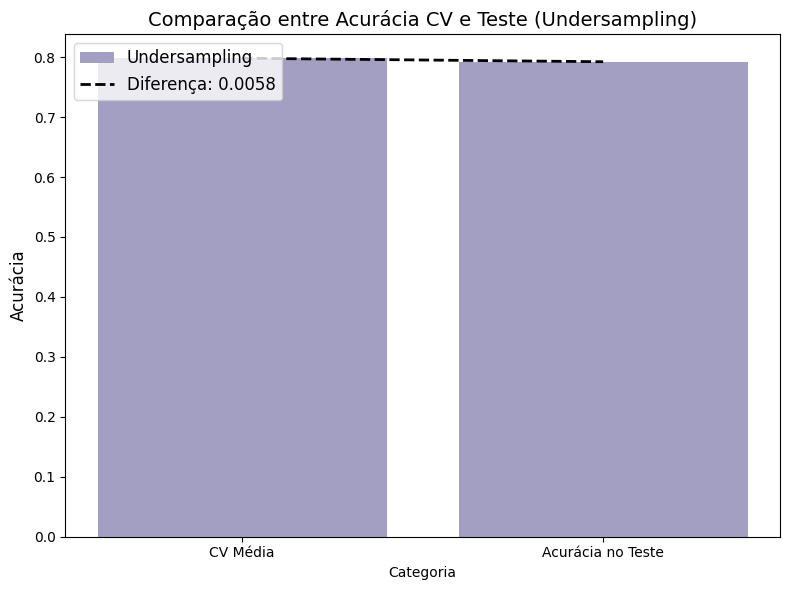

In [17]:
# Verificação de Overfitting
limiar = 0.05
diff_undersampled = abs(cv_mean - acc_test)

if diff_undersampled > limiar:
    print("\nAtenção: Diferença significativa entre CV (treino undersampled) e teste.")
    print(f"→ CV Média: {cv_mean:.4f}")
    print(f"→ Teste   : {acc_test:.4f}")
    print(f"→ Diferença: {diff_undersampled:.4f}")
    print("Possível overfitting ou distribuição diferente entre treino/teste.")
else:
    print("\nModelo generaliza bem com base na comparação CV treino undersampled vs Teste.")

data_undersampled = pd.DataFrame({
    "Categoria": ["CV Média", "Acurácia no Teste"],
    "Acurácia": [cv_mean, acc_test],
    "Modelo": ["Undersampling"] * 2
})
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x="Categoria", y="Acurácia", data=data_undersampled, ax=ax, palette='Purples', hue="Modelo")
ax.plot([0, 1], [cv_mean, acc_test], 'k--', lw=2, label=f'Diferença: {diff_undersampled:.4f}')
ax.legend(loc='upper left', fontsize=12)
ax.set_title('Comparação entre Acurácia CV e Teste (Undersampling)', fontsize=14)
ax.set_ylabel('Acurácia', fontsize=12)
plt.tight_layout()
plt.show()

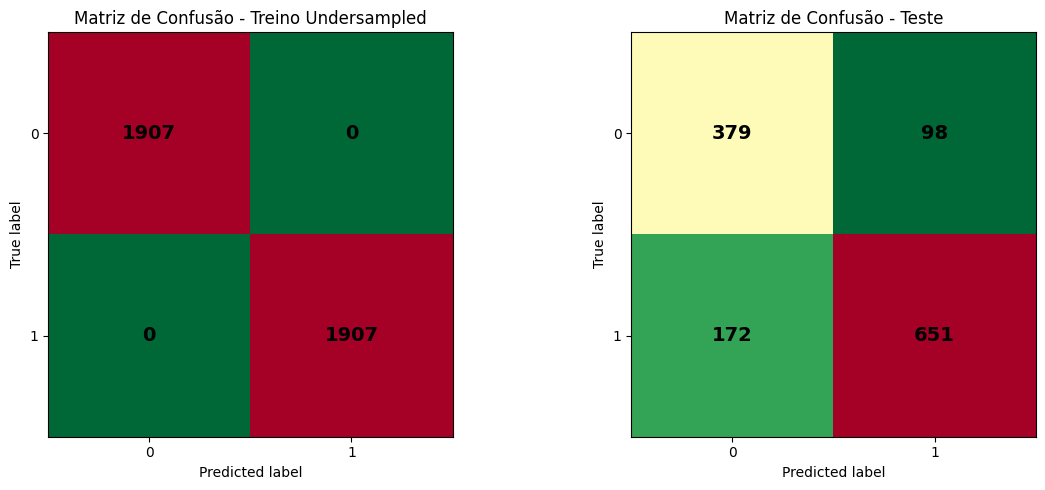

In [18]:
# Matrizes de Confusão
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(
    best_knn, X_train_bal_scaled, y_train_bal,
    ax=axes[0],
    cmap='RdYlGn_r',
    colorbar=False
)
axes[0].set_title("Matriz de Confusão - Treino Undersampled")

ConfusionMatrixDisplay.from_estimator(
    best_knn, X_test_scaled, y_test,
    ax=axes[1],
    cmap='RdYlGn_r',
    colorbar=False
)
axes[1].set_title("Matriz de Confusão - Teste")

def style_confusion_texts(ax, color='black', weight='bold', fontsize=14):
    for text in ax.texts:
        text.set_color(color)
        text.set_fontweight(weight)
        text.set_fontsize(fontsize)

style_confusion_texts(axes[0])
style_confusion_texts(axes[1])

plt.tight_layout()
plt.show()

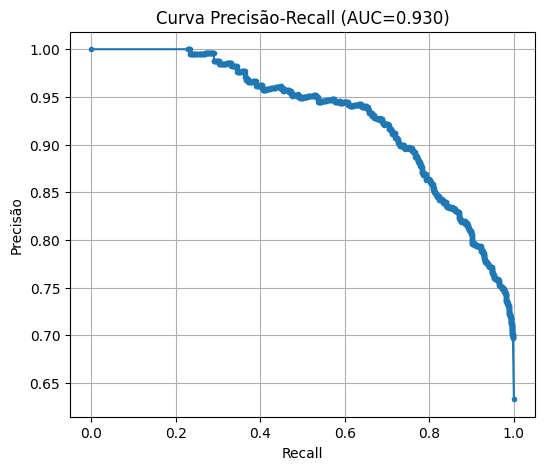

In [19]:
# Curva de Precisão-Recall
precisao, recall, _ = precision_recall_curve(y_test, best_knn.predict_proba(X_test_scaled)[:,1])
pr_auc = auc(recall, precisao)

plt.figure(figsize=(6,5))
plt.plot(recall, precisao, marker='.')
plt.title(f'Curva Precisão-Recall (AUC={pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.grid(True)
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

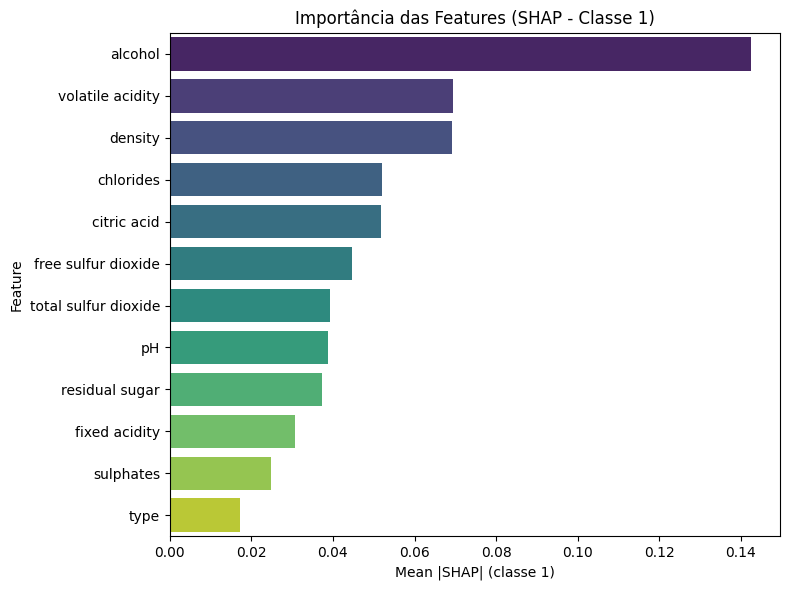


Importância média das características para prever vinhos bons:
                 Feature  Mean |SHAP| (classe 1)
11               alcohol                0.142437
2       volatile acidity                0.069429
8                density                0.069233
5              chlorides                0.052026
3            citric acid                0.051814
6    free sulfur dioxide                0.044707
7   total sulfur dioxide                0.039170
9                     pH                0.038916
4         residual sugar                0.037258
1          fixed acidity                0.030780
10             sulphates                0.024895
0                   type                0.017331


In [ ]:
# SHAP - Explicabilidade
# (classe 1 = vinho bom)

feature_names = X.columns.tolist()
X_shap_train = pd.DataFrame(X_train_bal_scaled[:100], columns=feature_names)
X_shap_test = pd.DataFrame(X_test_scaled[:50], columns=feature_names)

def predict_proba_class(X_array):
    return best_knn.predict_proba(X_array)

explainer = shap.KernelExplainer(predict_proba_class, X_shap_train)

shap_values = explainer.shap_values(X_shap_test)

if isinstance(shap_values, list):
    if len(shap_values) == 2:
        shap_values_class1 = shap_values[1]
    else:
        raise ValueError("Esperava-se shap_values como lista com 2 elementos para problema binário.")
elif isinstance(shap_values, np.ndarray):
    shap_values_class1 = shap_values
else:
    raise ValueError("Estrutura inesperada para shap_values.")

mean_abs_shap_1 = np.abs(shap_values_class1[:, :, 1]).mean(axis=0)

if mean_abs_shap_1.shape[0] != len(feature_names):
    raise ValueError(f"Mismatch entre número de features e tamanho do vetor de importância! ({mean_abs_shap_1.shape[0]} vs {len(feature_names)})")

mean_abs_shap_1 = mean_abs_shap_1.flatten()

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Mean |SHAP| (classe 1)': mean_abs_shap_1
}).sort_values(by='Mean |SHAP| (classe 1)', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='Mean |SHAP| (classe 1 = Vinho Bom)', y='Feature', data=feature_importance, hue='Feature', legend=False, palette='viridis')
plt.title('Importância das Features (SHAP - Classe 1 = Vinho Bom) Undersampling')
plt.tight_layout()
plt.show()

print("\nImportância média das características para prever vinhos bons:")
print(feature_importance)

Seção 2: KNN + Oversampling

In [20]:
# Balanceamento com Oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)
print(f'\nAntes do oversampling, treino tem {np.bincount(y_train)}')
print(f'Depois do oversampling, treino tem {np.bincount(y_train_oversampled)}')


Antes do oversampling, treino tem [1907 3290]
Depois do oversampling, treino tem [3290 3290]


In [22]:
# Normalização dos dados (fit no treino balanceado, aplicando em treino e teste)
scaler = StandardScaler()
X_train_oversampled_scaled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(X_test)

In [23]:
# Ajuste de Hiperparâmetros com Cross-validation
grid.fit(X_train_oversampled_scaled, y_train_oversampled)
print("\nMelhores parâmetros encontrados (com oversampling):", grid.best_params_)
best_knn_oversampled = grid.best_estimator_


Melhores parâmetros encontrados (com oversampling): {'n_neighbors': 45, 'p': 1, 'weights': 'distance'}


In [24]:
# Avaliação de métricas
tabela_metricas_oversampled = gerar_tabela_metricas(
    best_knn_oversampled, X_train_oversampled_scaled, y_train_oversampled, X_test_scaled, y_test
)
print("\n===== Tabela de Métricas (com RandomOverSampler) =====")
print(tabela_metricas_oversampled)
acc_train_oversampled = accuracy_score(y_train_oversampled, best_knn_oversampled.predict(X_train_oversampled_scaled))
acc_test_oversampled = accuracy_score(y_test, best_knn_oversampled.predict(X_test_scaled))
print(f"\nAcurácia Treino (Oversampling): {acc_train_oversampled:.4f}")
print(f"Acurácia Teste (Oversampling) : {acc_test_oversampled:.4f}")


===== Tabela de Métricas (com RandomOverSampler) =====
                Vinhos Ruins Vinhos Bons     Média Média Ponderada
Teste  Precisão     0.718095    0.870968  0.794531        0.814875
       Recall       0.790356     0.82017  0.805263        0.809231
       F1-Score     0.752495    0.844806  0.798651        0.810935
       Suporte         477.0       823.0       NaN             NaN
Treino Precisão          1.0         1.0       1.0             1.0
       Recall            1.0         1.0       1.0             1.0
       F1-Score          1.0         1.0       1.0             1.0
       Suporte        3290.0      3290.0       NaN             NaN

Acurácia Treino (Oversampling): 1.0000
Acurácia Teste (Oversampling) : 0.8092


In [25]:
# Cross-validation para KNN com Oversampling
cv_scores_oversampled = cross_val_score(best_knn_oversampled, X_train_oversampled_scaled, y_train_oversampled, cv=5, scoring='accuracy')
cv_mean_oversampled = cv_scores_oversampled.mean()
cv_std_oversampled = cv_scores_oversampled.std()

print(f"\nCross-Validation Accuracy (Treino oversampled): {cv_mean_oversampled:.4f} ± {cv_std_oversampled:.4f}")


Cross-Validation Accuracy (Treino oversampled): 0.8818 ± 0.0188



Atenção: Diferença significativa entre CV (treino oversampled) e teste.
→ CV Média: 0.8818
→ Teste   : 0.7923
→ Diferença: 0.0895
Possível overfitting ou distribuição diferente entre treino/teste.


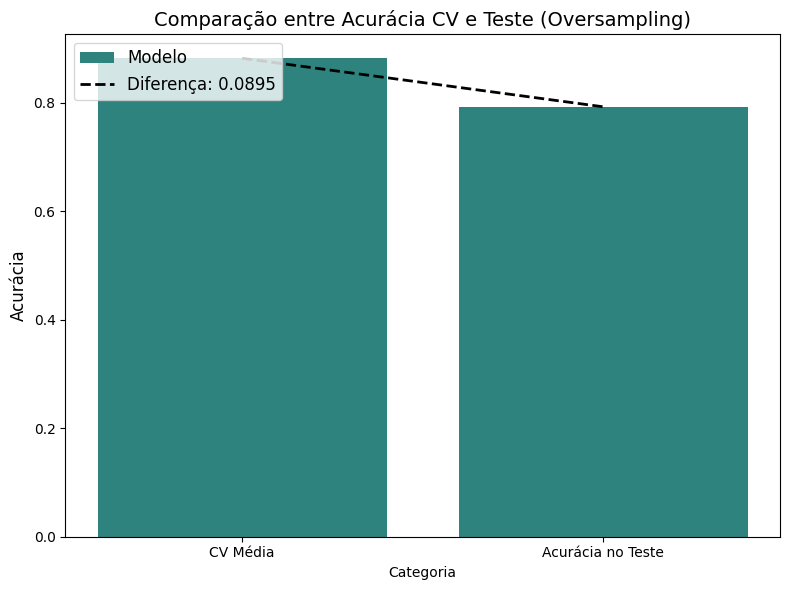

In [26]:
# Verificação de Overfitting para KNN com Oversampling
diff = abs(cv_mean_oversampled - acc_test)
limiar = 0.05

if diff > limiar:
    print("\nAtenção: Diferença significativa entre CV (treino oversampled) e teste.")
    print(f"→ CV Média: {cv_mean_oversampled:.4f}")
    print(f"→ Teste   : {acc_test:.4f}")
    print(f"→ Diferença: {diff:.4f}")
    print("Possível overfitting ou distribuição diferente entre treino/teste.")
else:
    print("\nModelo generaliza bem com base na comparação CV treino oversampled vs Teste.")

data = pd.DataFrame({
    "Categoria": ["CV Média", "Acurácia no Teste"],
    "Acurácia": [cv_mean_oversampled, acc_test],
    "Modelo": ["Modelo"] * 2
})
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x="Categoria", y="Acurácia", data=data, ax=ax, palette='viridis', hue="Modelo")
ax.plot([0, 1], [cv_mean_oversampled, acc_test], 'k--', lw=2, label=f'Diferença: {diff:.4f}')  # Linha pontilhada com legenda
ax.legend(loc='upper left', fontsize=12)
ax.set_title('Comparação entre Acurácia CV e Teste (Oversampling)', fontsize=14)
ax.set_ylabel('Acurácia', fontsize=12)
plt.tight_layout()
plt.show()

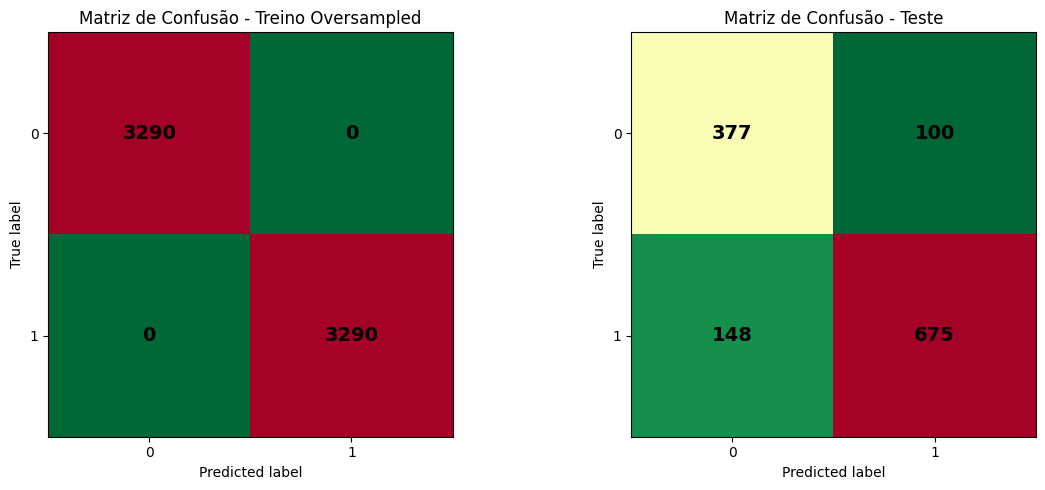

In [27]:
# Matrizes de Confusão
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(
    best_knn_oversampled, X_train_oversampled_scaled, y_train_oversampled,
    ax=axes[0],
    cmap='RdYlGn_r',
    colorbar=False
)
axes[0].set_title("Matriz de Confusão - Treino Oversampled")

ConfusionMatrixDisplay.from_estimator(
    best_knn_oversampled, X_test_scaled, y_test,
    ax=axes[1],
    cmap='RdYlGn_r',
    colorbar=False
)
axes[1].set_title("Matriz de Confusão - Teste")

def style_confusion_texts(ax, color='black', weight='bold', fontsize=14):
    for text in ax.texts:
        text.set_color(color)
        text.set_fontweight(weight)
        text.set_fontsize(fontsize)

style_confusion_texts(axes[0])
style_confusion_texts(axes[1])

plt.tight_layout()
plt.show()

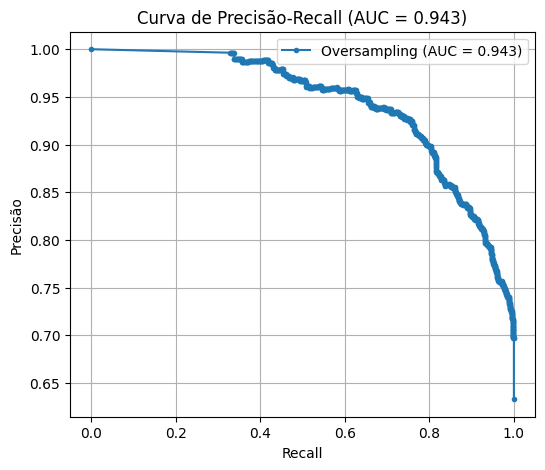

In [28]:
# Curva de Precisão-Recall
precisao, recall, _ = precision_recall_curve(y_test, best_knn_oversampled.predict_proba(X_test_scaled)[:, 1])
pr_auc = auc(recall, precisao)
plt.figure(figsize=(6, 5))
plt.plot(recall, precisao, marker='.', label=f'Oversampling (AUC = {pr_auc:.3f})')
plt.title(f'Curva de Precisão-Recall (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.grid(True)
plt.legend()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

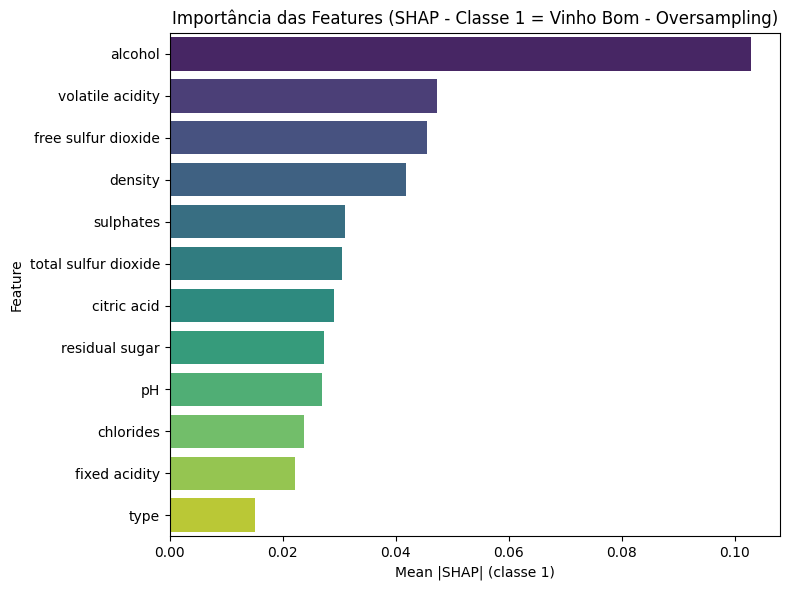


Importância média das características para prever vinhos bons (oversampling):
                 Feature  Mean |SHAP| (classe 1)
11               alcohol                0.102897
2       volatile acidity                0.047309
6    free sulfur dioxide                0.045594
8                density                0.041869
10             sulphates                0.031098
7   total sulfur dioxide                0.030452
3            citric acid                0.029155
4         residual sugar                0.027236
9                     pH                0.026999
5              chlorides                0.023798
1          fixed acidity                0.022157
0                   type                0.015149


In [86]:
# SHAP - Explicabilidade para Oversampling
feature_names = X_train.columns.tolist()
X_shap_train_oversampled = pd.DataFrame(X_train_oversampled_scaled[:100], columns=feature_names)
X_shap_test_oversampled = pd.DataFrame(X_test_scaled[:50], columns=feature_names)

explainer_oversampled = shap.KernelExplainer(best_knn_oversampled.predict_proba, X_shap_train_oversampled)
shap_values_oversampled = explainer_oversampled.shap_values(X_shap_test_oversampled)

if isinstance(shap_values_oversampled, list):
    if len(shap_values_oversampled) == 2:
        shap_values_class1 = shap_values_oversampled[1]  # Classe 1 (Vinho Bom)
    else:
        raise ValueError("Esperava-se shap_values como lista com 2 elementos para problema binário.")
elif isinstance(shap_values_oversampled, np.ndarray):
    shap_values_class1 = shap_values_oversampled
else:
    raise ValueError("Estrutura inesperada para shap_values.")

shap_values_class1 = shap_values_class1[:, :, 1]

mean_abs_shap_1_oversampled = np.abs(shap_values_class1).mean(axis=0)

if mean_abs_shap_1_oversampled.shape[0] != len(feature_names):
    raise ValueError(f"Mismatch entre número de features e tamanho do vetor de importância! ({mean_abs_shap_1_oversampled.shape[0]} vs {len(feature_names)})")

mean_abs_shap_1_oversampled = mean_abs_shap_1_oversampled.flatten()

feature_importance_oversampled = pd.DataFrame({
    'Feature': feature_names,
    'Mean |SHAP| (classe 1)': mean_abs_shap_1_oversampled
}).sort_values(by='Mean |SHAP| (classe 1)', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Mean |SHAP| (classe 1)', y='Feature', data=feature_importance_oversampled, palette='viridis', hue='Feature', legend=False)
plt.title('Importância das Features (SHAP - Classe 1 = Vinho Bom - Oversampling)')
plt.tight_layout()
plt.show()

print("\nImportância média das características para prever vinhos bons (oversampling):")
print(feature_importance_oversampled)

Seção 3: KNN + SMOTE

In [29]:
# Balanceamento com SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f'\nAntes do SMOTE, treino tem {np.bincount(y_train)}')
print(f'Depois do SMOTE, treino tem {np.bincount(y_train_smote)}')


Antes do SMOTE, treino tem [1907 3290]
Depois do SMOTE, treino tem [3290 3290]


In [30]:
# Normalização dos dados (fit no treino balanceado, aplicando em treino e teste)
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

In [31]:
# Ajuste de Hiperparâmetros com Cross-validation
grid.fit(X_train_smote_scaled, y_train_smote)
print("\nMelhores parâmetros encontrados (com SMOTE):", grid.best_params_)
best_knn_smote = grid.best_estimator_


Melhores parâmetros encontrados (com SMOTE): {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


In [32]:
# Avaliação de métricas
tabela_metricas_smote = gerar_tabela_metricas(
    best_knn_smote, X_train_smote_scaled, y_train_smote, X_test_scaled, y_test
)
print("\n===== Tabela de Métricas (com SMOTE) =====")
print(tabela_metricas_smote)
acc_train_smote = accuracy_score(y_train_smote, best_knn_smote.predict(X_train_smote_scaled))
acc_test_smote = accuracy_score(y_test, best_knn_smote.predict(X_test_scaled))
print(f"\nAcurácia Treino (SMOTE): {acc_train_smote:.4f}")
print(f"Acurácia Teste (SMOTE) : {acc_test_smote:.4f}")


===== Tabela de Métricas (com SMOTE) =====
                Vinhos Ruins Vinhos Bons     Média Média Ponderada
Teste  Precisão     0.732943    0.871665  0.802304        0.820765
       Recall        0.78826    0.833536  0.810898        0.816923
       F1-Score     0.759596    0.852174  0.805885        0.818205
       Suporte         477.0       823.0       NaN             NaN
Treino Precisão          1.0         1.0       1.0             1.0
       Recall            1.0         1.0       1.0             1.0
       F1-Score          1.0         1.0       1.0             1.0
       Suporte        3290.0      3290.0       NaN             NaN

Acurácia Treino (SMOTE): 1.0000
Acurácia Teste (SMOTE) : 0.8169


In [33]:
# Cross-validation para KNN com SMOTE
cv_scores_smote = cross_val_score(best_knn_smote, X_train_smote_scaled, y_train_smote, cv=5, scoring='accuracy')
cv_mean_smote = cv_scores_smote.mean()
cv_std_smote = cv_scores_smote.std()
print(f"\nCross-Validation Accuracy (Treino SMOTE): {cv_mean_smote:.4f} ± {cv_std_smote:.4f}")


Cross-Validation Accuracy (Treino SMOTE): 0.8441 ± 0.0172



Modelo generaliza bem com base na comparação CV treino SMOTE vs Teste.


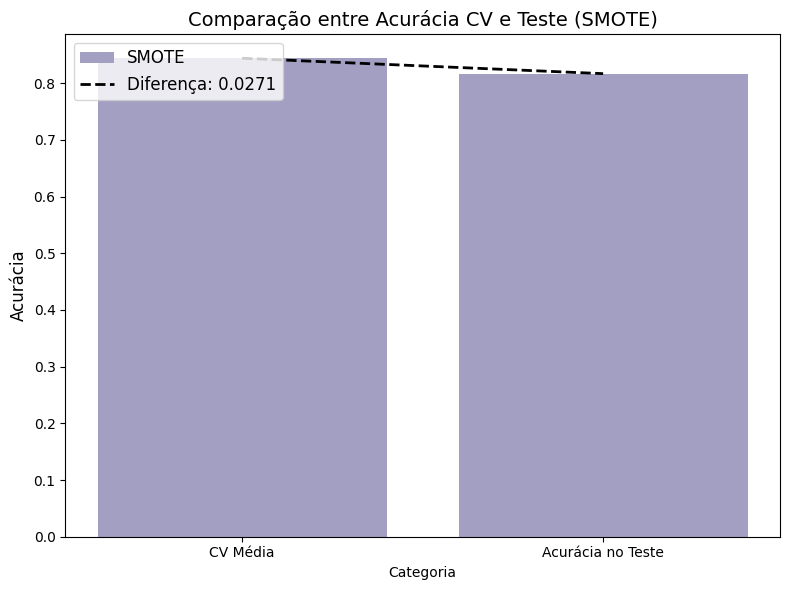

In [34]:
# Verificação de Overfitting para KNN com SMOTE
diff_smote = abs(cv_mean_smote - acc_test_smote)
limiar = 0.05

if diff_smote > limiar:
    print("\nAtenção: Diferença significativa entre CV (treino SMOTE) e teste.")
    print(f"→ CV Média: {cv_mean_smote:.4f}")
    print(f"→ Teste   : {acc_test_smote:.4f}")
    print(f"→ Diferença: {diff_smote:.4f}")
    print("Possível overfitting ou distribuição diferente entre treino/teste.")
else:
    print("\nModelo generaliza bem com base na comparação CV treino SMOTE vs Teste.")

data_smote = pd.DataFrame({
    "Categoria": ["CV Média", "Acurácia no Teste"],
    "Acurácia": [cv_mean_smote, acc_test_smote],
    "Modelo": ["SMOTE"] * 2
})

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x="Categoria", y="Acurácia", data=data_smote, ax=ax, palette='Purples', hue="Modelo")
ax.plot([0, 1], [cv_mean_smote, acc_test_smote], 'k--', lw=2, label=f'Diferença: {diff_smote:.4f}')
ax.legend(loc='upper left', fontsize=12)
ax.set_title('Comparação entre Acurácia CV e Teste (SMOTE)', fontsize=14)
ax.set_ylabel('Acurácia', fontsize=12)
plt.tight_layout()
plt.show()

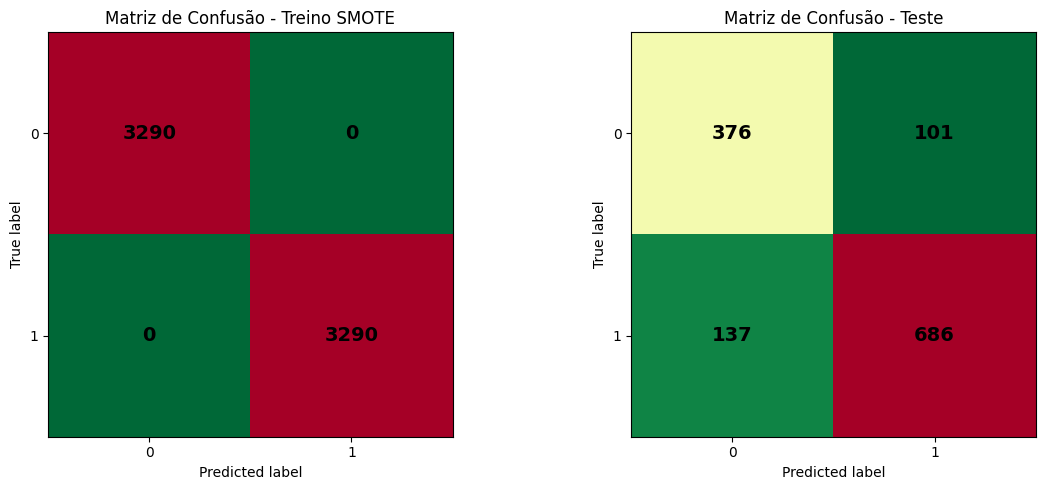

In [35]:
# Matrizes de Confusão para SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(
    best_knn_smote, X_train_smote_scaled, y_train_smote,
    ax=axes[0],
    cmap='RdYlGn_r',
    colorbar=False
)
axes[0].set_title("Matriz de Confusão - Treino SMOTE")

ConfusionMatrixDisplay.from_estimator(
    best_knn_smote, X_test_scaled, y_test,
    ax=axes[1],
    cmap='RdYlGn_r',
    colorbar=False
)
axes[1].set_title("Matriz de Confusão - Teste")
style_confusion_texts(axes[0])
style_confusion_texts(axes[1])
plt.tight_layout()
plt.show()

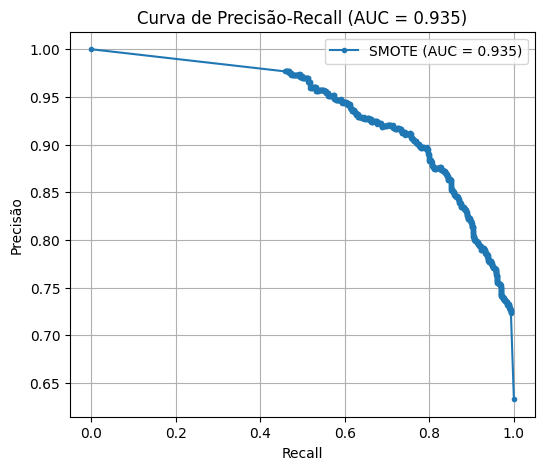

In [36]:
# Curva de Precisão-Recall para SMOTE
precisao, recall, _ = precision_recall_curve(y_test, best_knn_smote.predict_proba(X_test_scaled)[:, 1])
pr_auc_smote = auc(recall, precisao)

plt.figure(figsize=(6, 5))
plt.plot(recall, precisao, marker='.', label=f'SMOTE (AUC = {pr_auc_smote:.3f})')
plt.title(f'Curva de Precisão-Recall (AUC = {pr_auc_smote:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.grid(True)
plt.legend()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

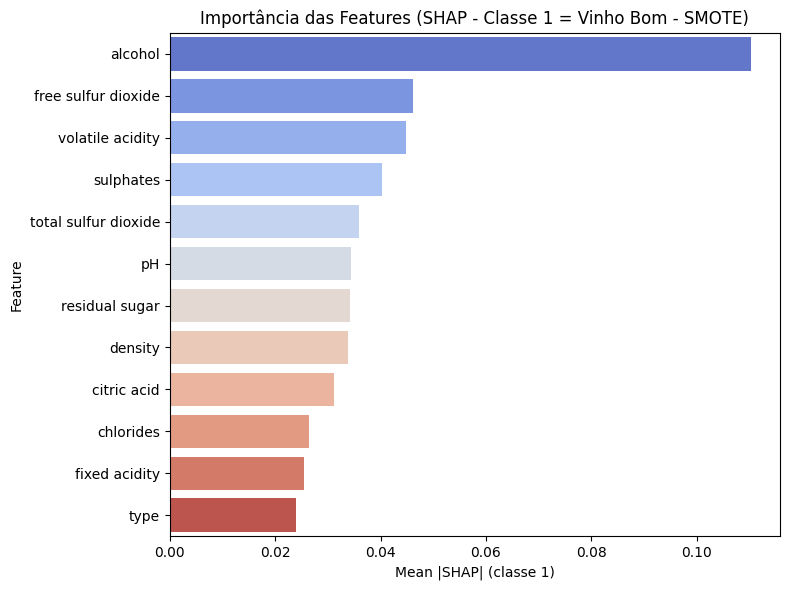


Importância média das características para prever vinhos bons (SMOTE):
                 Feature  Mean |SHAP| (classe 1)
11               alcohol                0.110250
6    free sulfur dioxide                0.046181
2       volatile acidity                0.044759
10             sulphates                0.040319
7   total sulfur dioxide                0.035928
9                     pH                0.034440
4         residual sugar                0.034207
8                density                0.033819
3            citric acid                0.031193
5              chlorides                0.026380
1          fixed acidity                0.025463
0                   type                0.023985


In [111]:
# SHAP - Explicabilidade para SMOTE
X_shap_train_smote = pd.DataFrame(X_train_smote_scaled[:100], columns=feature_names)
X_shap_test_smote = pd.DataFrame(X_test_scaled[:50], columns=feature_names)

explainer_smote = shap.KernelExplainer(best_knn_smote.predict_proba, X_shap_train_smote)
shap_values_smote = explainer_smote.shap_values(X_shap_test_smote)

if isinstance(shap_values_smote, list):
    if len(shap_values_smote) == 2:
        shap_values_class1 = shap_values_smote[1]  # Classe 1 (Vinho Bom)
    else:
        raise ValueError("Esperava-se shap_values como lista com 2 elementos para problema binário.")
elif isinstance(shap_values_smote, np.ndarray):
    shap_values_class1 = shap_values_smote
else:
    raise ValueError("Estrutura inesperada para shap_values.")

shap_values_class1 = shap_values_class1[:, :, 1]

mean_abs_shap_1_smote = np.abs(shap_values_class1).mean(axis=0)

if mean_abs_shap_1_smote.shape[0] != len(feature_names):
    raise ValueError(f"Mismatch entre número de features e tamanho do vetor de importância! ({mean_abs_shap_1_smote.shape[0]} vs {len(feature_names)})")

mean_abs_shap_1_smote = mean_abs_shap_1_smote.flatten()

feature_importance_smote = pd.DataFrame({
    'Feature': feature_names,
    'Mean |SHAP| (classe 1)': mean_abs_shap_1_smote
}).sort_values(by='Mean |SHAP| (classe 1)', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Mean |SHAP| (classe 1)', y='Feature', data=feature_importance_smote, palette='coolwarm', hue='Feature', legend=False)
plt.title('Importância das Features (SHAP - Classe 1 = Vinho Bom - SMOTE)')
plt.tight_layout()
plt.show()

print("\nImportância média das características para prever vinhos bons (SMOTE):")
print(feature_importance_smote)

Comparação KNN - Puro X Undersampling X Oversampling X SMOTE 

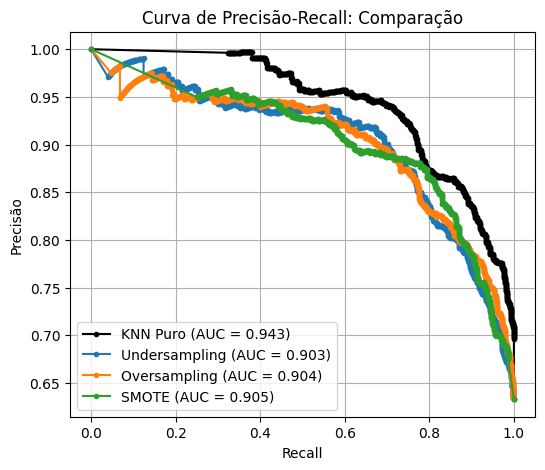

In [63]:
# Comparação: Curva de Precisão-Recall
precisao_os, recall_os, _ = precision_recall_curve(y_test, best_knn_oversampled.predict_proba(X_test_scaled)[:, 1])
pr_auc_os = auc(recall_os, precisao_os)

precisao_us, recall_us, _ = precision_recall_curve(y_test, best_knn.predict_proba(X_test_scaled)[:, 1])
pr_auc_us = auc(recall_us, precisao_us)

precisao_smote, recall_smote, _ = precision_recall_curve(y_test, best_knn_smote.predict_proba(X_test_scaled)[:, 1])
pr_auc_smote = auc(recall_smote, precisao_smote)

precisao_puro, recall_puro, _ = precision_recall_curve(y_test, best_knn_puro.predict_proba(X_test_scaled)[:, 1])
pr_auc_puro = auc(recall_puro, precisao_puro)

plt.figure(figsize=(6, 5))
plt.plot(recall_puro, precisao_puro, marker='.', label=f'KNN Puro (AUC = {pr_auc_puro:.3f})', linestyle='-', color='black')
plt.plot(recall_us, precisao_us, marker='.', label=f'Undersampling (AUC = {pr_auc_us:.3f})', linestyle='-')
plt.plot(recall_os, precisao_os, marker='.', label=f'Oversampling (AUC = {pr_auc_os:.3f})', linestyle='-')
plt.plot(recall_smote, precisao_smote, marker='.', label=f'SMOTE (AUC = {pr_auc_smote:.3f})', linestyle='-')
plt.title('Curva de Precisão-Recall: Comparação')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

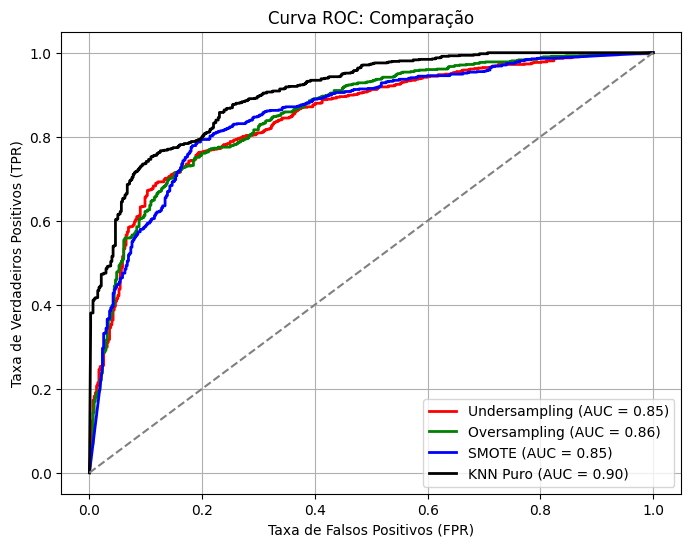

In [60]:
# Predições de probabilidade para a classe positiva
fpr_us, tpr_us, _ = roc_curve(y_test, best_knn.predict_proba(X_test_scaled)[:, 1])
fpr_os, tpr_os, _ = roc_curve(y_test, best_knn_oversampled.predict_proba(X_test_scaled)[:, 1])
fpr_smote, tpr_smote, _ = roc_curve(y_test, best_knn_smote.predict_proba(X_test_scaled)[:, 1])
fpr_puro, tpr_puro, _ = roc_curve(y_test, best_knn_puro.predict_proba(X_test_scaled)[:, 1])
# Cálculo da AUC
roc_auc_us = auc(fpr_us, tpr_us)
roc_auc_os = auc(fpr_os, tpr_os)
roc_auc_smote = auc(fpr_smote, tpr_smote)
roc_auc_puro = auc(fpr_puro, tpr_puro)
plt.figure(figsize=(8, 6))

plt.figure(figsize=(8, 6))
plt.plot(fpr_us, tpr_us, lw=2, label=f'Undersampling (AUC = {roc_auc_us:.2f})', linestyle='-', color='red')
plt.plot(fpr_os, tpr_os, lw=2, label=f'Oversampling (AUC = {roc_auc_os:.2f})', linestyle='-', color='green')
plt.plot(fpr_smote, tpr_smote, lw=2, label=f'SMOTE (AUC = {roc_auc_smote:.2f})', linestyle='-', color='blue')
plt.plot(fpr_puro, tpr_puro, lw=2, label=f'KNN Puro (AUC = {roc_auc_puro:.2f})', linestyle='-', color='black')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Linha de chance

plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC: Comparação')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

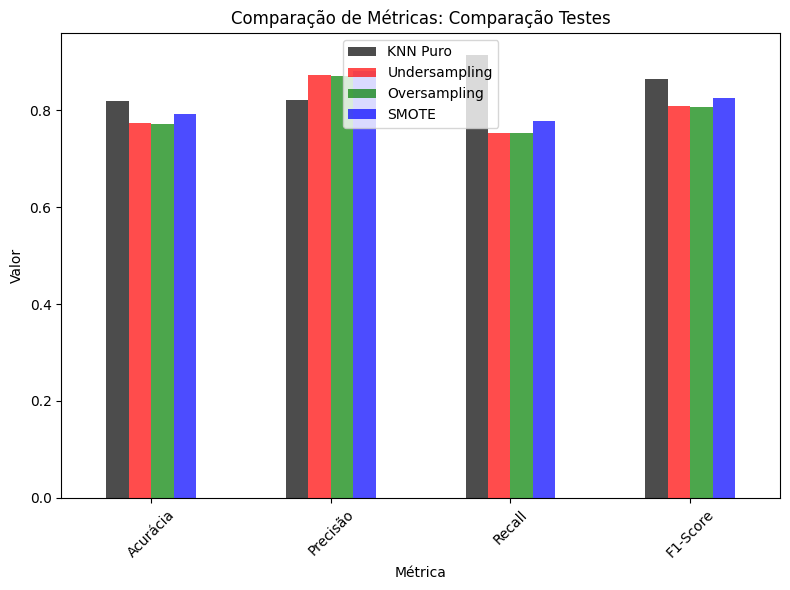

In [64]:
# Comparação de Métricas
acc_us = accuracy_score(y_test, best_knn.predict(X_test_scaled))
precision_us = precision_score(y_test, best_knn.predict(X_test_scaled))
recall_us = recall_score(y_test, best_knn.predict(X_test_scaled))
f1_us = f1_score(y_test, best_knn.predict(X_test_scaled))

acc_os = accuracy_score(y_test, best_knn_oversampled.predict(X_test_scaled))
precision_os = precision_score(y_test, best_knn_oversampled.predict(X_test_scaled))
recall_os = recall_score(y_test, best_knn_oversampled.predict(X_test_scaled))
f1_os = f1_score(y_test, best_knn_oversampled.predict(X_test_scaled))

acc_smote = accuracy_score(y_test, best_knn_smote.predict(X_test_scaled))
precision_smote = precision_score(y_test, best_knn_smote.predict(X_test_scaled))
recall_smote = recall_score(y_test, best_knn_smote.predict(X_test_scaled))
f1_smote = f1_score(y_test, best_knn_smote.predict(X_test_scaled))

acc_puro = accuracy_score(y_test, best_knn_puro.predict(X_test_scaled))
precision_puro = precision_score(y_test, best_knn_puro.predict(X_test_scaled))
recall_puro = recall_score(y_test, best_knn_puro.predict(X_test_scaled))
f1_puro = f1_score(y_test, best_knn_puro.predict(X_test_scaled))

metrics = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
df_metrics = pd.DataFrame({
    'Métrica': metrics,
    'KNN Puro': [acc_puro, precision_puro, recall_puro, f1_puro],
    'Undersampling': [acc_us, precision_us, recall_us, f1_us],
    'Oversampling': [acc_os, precision_os, recall_os, f1_os],
    'SMOTE': [acc_smote, precision_smote, recall_smote, f1_smote]
})

df_metrics.set_index('Métrica').plot(kind='bar', figsize=(8, 6), color=['black', 'red', 'green', 'blue'], alpha=0.7)
plt.title('Comparação de Métricas: Comparação Testes')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

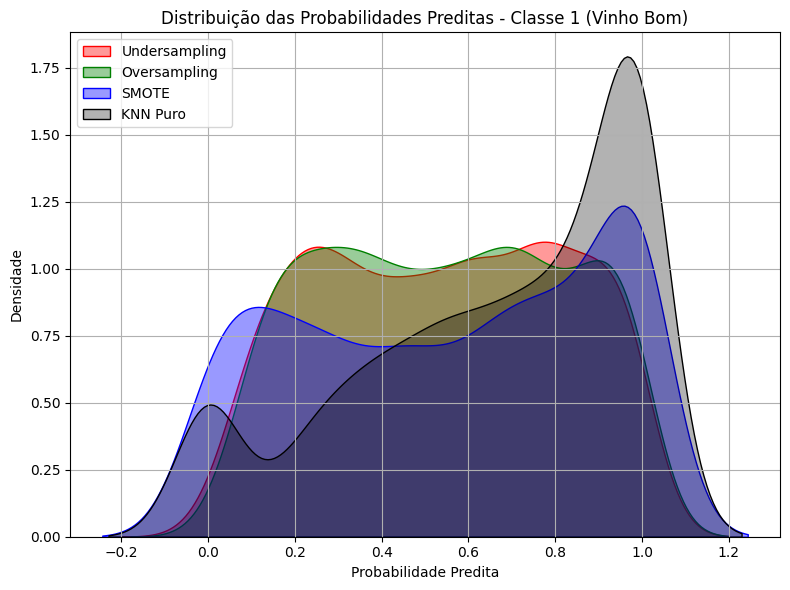

In [55]:
# Distribuição das Probabilidades Preditas para a classe 1 (bom)
plt.figure(figsize=(8, 6))

prob_us = best_knn.predict_proba(X_test_scaled)[:, 1]
prob_os = best_knn_oversampled.predict_proba(X_test_scaled)[:, 1]
prob_smote = best_knn_smote.predict_proba(X_test_scaled)[:, 1]
prob_puro = best_knn_puro.predict_proba(X_test_scaled)[:, 1]

sns.kdeplot(prob_us, label='Undersampling', fill=True, color='red', alpha=0.4)
sns.kdeplot(prob_os, label='Oversampling', fill=True, color='green', alpha=0.4)
sns.kdeplot(prob_smote, label='SMOTE', fill=True, color='blue', alpha=0.4)
sns.kdeplot(prob_puro, label='KNN Puro', fill=True, color='black', alpha=0.3)

plt.title('Distribuição das Probabilidades Preditas - Classe 1 (Vinho Bom)')
plt.xlabel('Probabilidade Predita')
plt.ylabel('Densidade')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

                Modelo  F1 Treino (classe 1)  F1 Teste (classe 1)  \
0             KNN Puro                   1.0             0.864865   
1  KNN + Undersampling                   1.0             0.808094   
2   KNN + Oversampling                   1.0             0.806515   
3          KNN + SMOTE                   1.0             0.825806   

   Diferença F1  Precisão Treino  Precisão Teste  Diferença Precisão  \
0      0.135135              1.0        0.820961            0.179039   
1      0.191906              1.0        0.873061            0.126939   
2      0.193485              1.0        0.869382            0.130618   
3      0.174194              1.0        0.880330            0.119670   

   Recall Treino  Recall Teste  Diferença Recall  Acc Treino  Acc Teste  \
0            1.0      0.913730          0.086270         1.0   0.819231   
1            1.0      0.752126          0.247874         1.0   0.773846   
2            1.0      0.752126          0.247874         1.0   0.771

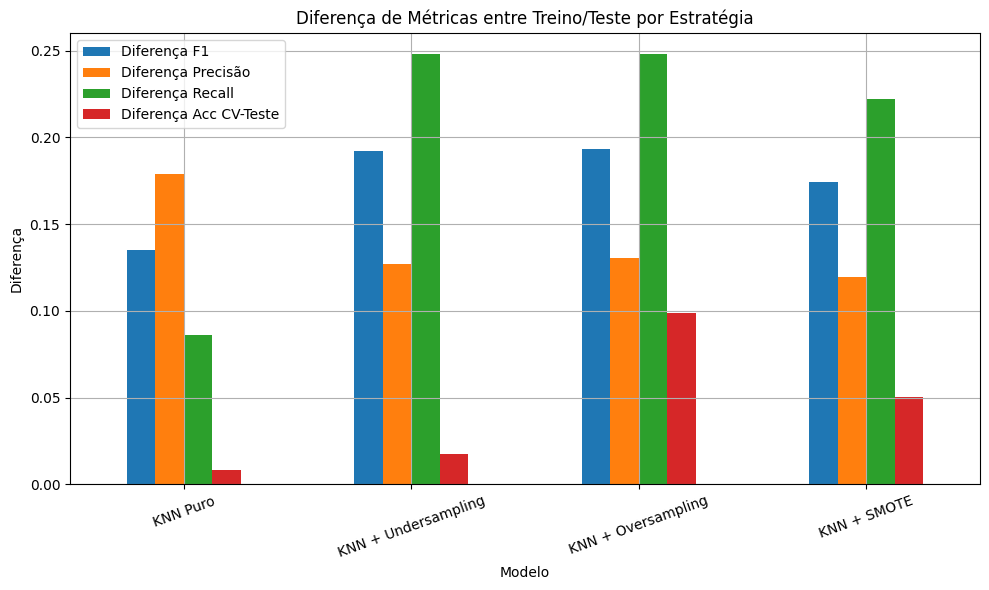

In [ ]:
# Verificação de Overfitting Melhorada p/ Vinhos Bons
def avaliar_overfitting(nome_modelo, modelo, X_train, y_train, X_test, y_test):
    # F1-score no treino/teste
    f1_train = classification_report(y_train, modelo.predict(X_train), output_dict=True)['1']['f1-score']
    f1_test = classification_report(y_test, modelo.predict(X_test), output_dict=True)['1']['f1-score']
    f1_diff = abs(f1_train - f1_test)
    # Acurácia no treino/teste
    acc_train = accuracy_score(y_train, modelo.predict(X_train))
    acc_test = accuracy_score(y_test, modelo.predict(X_test))
    # Precisão no treino/teste
    precision_train = classification_report(y_train, modelo.predict(X_train), output_dict=True)['1']['precision']
    precision_test = classification_report(y_test, modelo.predict(X_test), output_dict=True)['1']['precision']
    precision_diff = abs(precision_train - precision_test)
    # Recall no treino/teste
    recall_train = classification_report(y_train, modelo.predict(X_train), output_dict=True)['1']['recall']
    recall_test = classification_report(y_test, modelo.predict(X_test), output_dict=True)['1']['recall']
    recall_diff = abs(recall_train - recall_test)
    # Cross-validation estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(modelo, X_train, y_train, cv=skf, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    diff_acc = abs(cv_mean - acc_test)

    df_result = pd.DataFrame({
        'Modelo': [nome_modelo],
        'F1 Treino (classe 1)': [f1_train],
        'F1 Teste (classe 1)': [f1_test],
        'Diferença F1': [f1_diff],
        'Precisão Treino': [precision_train],
        'Precisão Teste': [precision_test],
        'Diferença Precisão': [precision_diff],
        'Recall Treino': [recall_train],
        'Recall Teste': [recall_test],
        'Diferença Recall': [recall_diff],
        'Acc Treino': [acc_train],
        'Acc Teste': [acc_test],
        'CV Mean': [cv_mean],
        'CV Std': [cv_std],
        'Diferença Acc CV-Teste': [diff_acc]
    })
    return df_result

df_puro = avaliar_overfitting(
    "KNN Puro", best_knn_puro, X_train_scaled, y_train, X_test_scaled, y_test)
df_under = avaliar_overfitting(
    "KNN + Undersampling", best_knn, X_train_bal_scaled, y_train_bal, X_test_scaled, y_test)
df_over = avaliar_overfitting(
    "KNN + Oversampling", best_knn_oversampled, X_train_oversampled_scaled, y_train_oversampled, X_test_scaled, y_test)
df_smote = avaliar_overfitting(
    "KNN + SMOTE", best_knn_smote, X_train_smote_scaled, y_train_smote, X_test_scaled, y_test)

df_resultado_total = pd.concat([df_puro, df_under, df_over, df_smote], ignore_index=True)
print(df_resultado_total)

df_resultado_total.set_index('Modelo')[['Diferença F1', 'Diferença Precisão', 'Diferença Recall', 'Diferença Acc CV-Teste']].plot(kind='bar', figsize=(10,6))
plt.title("Diferença de Métricas entre Treino/Teste por Estratégia")
plt.ylabel("Diferença")
plt.xticks(rotation=20)
plt.grid(True)
plt.tight_layout()
plt.show()

                Modelo  F1 Treino (classe 0)  F1 Teste (classe 0)  \
0             KNN Puro                   1.0             0.727062   
1  KNN + Undersampling                   1.0             0.724719   
2   KNN + Oversampling                   1.0             0.721127   
3          KNN + SMOTE                   1.0             0.742857   

   Diferença F1  Precisão Treino (classe 0)  Precisão Teste (classe 0)  \
0      0.272938                         1.0                   0.815104   
1      0.275281                         1.0                   0.654822   
2      0.278873                         1.0                   0.653061   
3      0.257143                         1.0                   0.680628   

   Diferença Precisão  Recall Treino (classe 0)  Recall Teste (classe 0)  \
0            0.184896                       1.0                 0.656184   
1            0.345178                       1.0                 0.811321   
2            0.346939                       1.0        

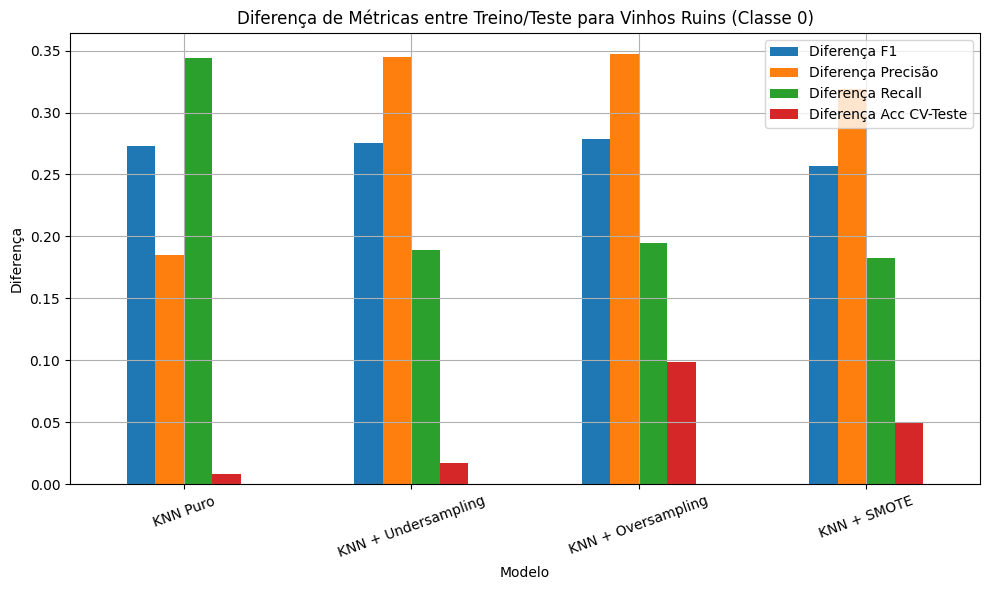

In [74]:
# Verificação de Overfitting Melhorada p/ Vinhos Ruins
def avaliar_overfitting_ruins(nome_modelo, modelo, X_train, y_train, X_test, y_test):
    # F1-score no treino/teste (classe 0)
    f1_train = classification_report(y_train, modelo.predict(X_train), output_dict=True)['0']['f1-score']
    f1_test = classification_report(y_test, modelo.predict(X_test), output_dict=True)['0']['f1-score']
    f1_diff = abs(f1_train - f1_test)
    # Acurácia no treino/teste
    acc_train = accuracy_score(y_train, modelo.predict(X_train))
    acc_test = accuracy_score(y_test, modelo.predict(X_test))
    # Precisão no treino/teste (classe 0)
    precision_train = classification_report(y_train, modelo.predict(X_train), output_dict=True)['0']['precision']
    precision_test = classification_report(y_test, modelo.predict(X_test), output_dict=True)['0']['precision']
    precision_diff = abs(precision_train - precision_test)
    # Recall no treino/teste (classe 0)
    recall_train = classification_report(y_train, modelo.predict(X_train), output_dict=True)['0']['recall']
    recall_test = classification_report(y_test, modelo.predict(X_test), output_dict=True)['0']['recall']
    recall_diff = abs(recall_train - recall_test)
    # Cross-validation estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(modelo, X_train, y_train, cv=skf, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    diff_acc = abs(cv_mean - acc_test)

    df_result = pd.DataFrame({
        'Modelo': [nome_modelo],
        'F1 Treino (classe 0)': [f1_train],
        'F1 Teste (classe 0)': [f1_test],
        'Diferença F1': [f1_diff],
        'Precisão Treino (classe 0)': [precision_train],
        'Precisão Teste (classe 0)': [precision_test],
        'Diferença Precisão': [precision_diff],
        'Recall Treino (classe 0)': [recall_train],
        'Recall Teste (classe 0)': [recall_test],
        'Diferença Recall': [recall_diff],
        'Acc Treino': [acc_train],
        'Acc Teste': [acc_test],
        'CV Mean': [cv_mean],
        'CV Std': [cv_std],
        'Diferença Acc CV-Teste': [diff_acc]
    })
    return df_result

df_puro = avaliar_overfitting_ruins(
    "KNN Puro", best_knn_puro, X_train_scaled, y_train, X_test_scaled, y_test)
df_under = avaliar_overfitting_ruins(
    "KNN + Undersampling", best_knn, X_train_bal_scaled, y_train_bal, X_test_scaled, y_test)
df_over = avaliar_overfitting_ruins(
    "KNN + Oversampling", best_knn_oversampled, X_train_oversampled_scaled, y_train_oversampled, X_test_scaled, y_test)
df_smote = avaliar_overfitting_ruins(
    "KNN + SMOTE", best_knn_smote, X_train_smote_scaled, y_train_smote, X_test_scaled, y_test)

df_resultado_total = pd.concat([df_puro, df_under, df_over, df_smote], ignore_index=True)
print(df_resultado_total)

df_resultado_total.set_index('Modelo')[['Diferença F1', 'Diferença Precisão', 'Diferença Recall', 'Diferença Acc CV-Teste']].plot(kind='bar', figsize=(10,6))
plt.title("Diferença de Métricas entre Treino/Teste para Vinhos Ruins (Classe 0)")
plt.ylabel("Diferença")
plt.xticks(rotation=20)
plt.grid(True)
plt.tight_layout()
plt.show()

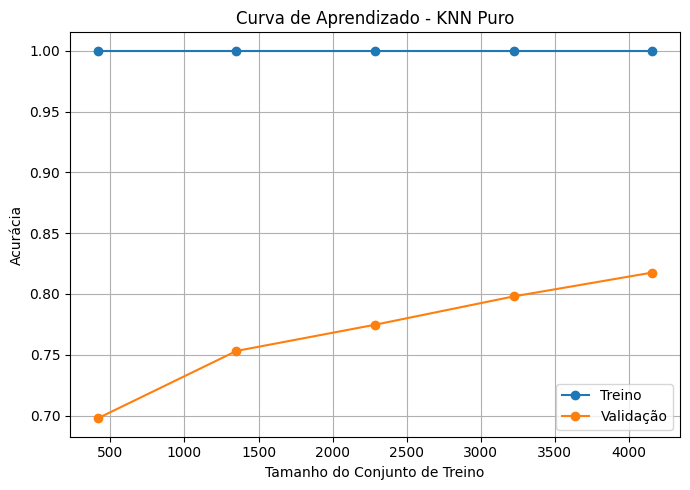

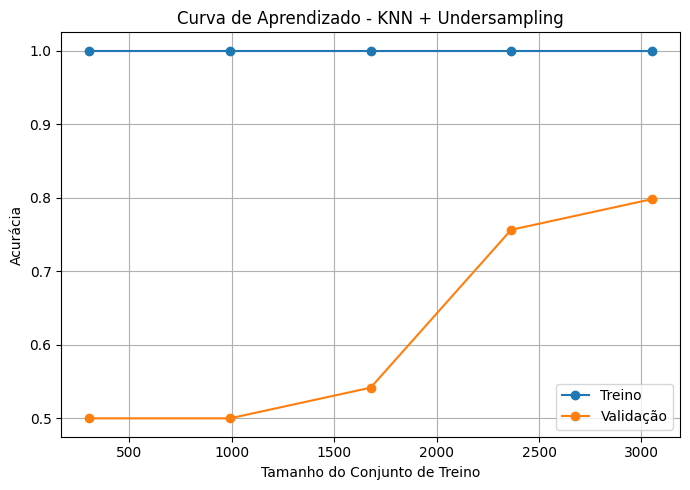

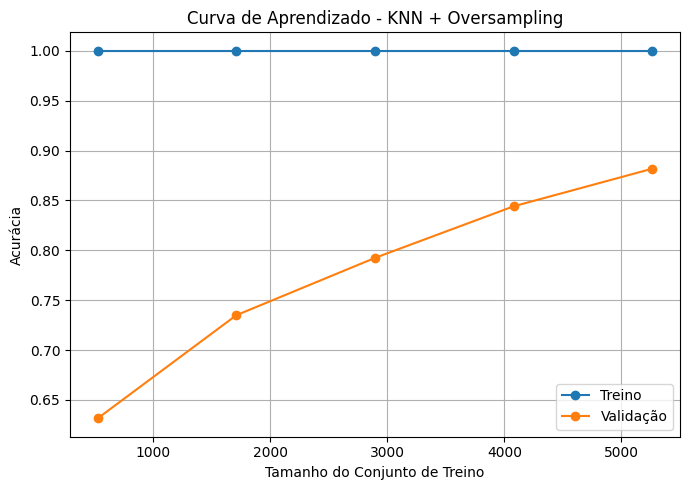

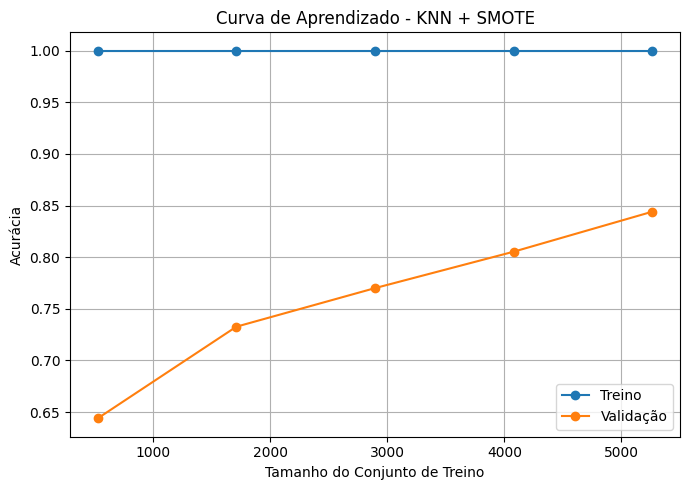

In [75]:
# Curva de Aprendizado
def plotar_curva_aprendizado(nome_modelo, modelo, X_train, y_train):
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    
    train_sizes, train_scores, val_scores = learning_curve(
        modelo, X_train, y_train, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    plt.figure(figsize=(7, 5))
    plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Treino')
    plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validação')
    plt.title(f'Curva de Aprendizado - {nome_modelo}')
    plt.xlabel('Tamanho do Conjunto de Treino')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plotar_curva_aprendizado("KNN Puro", best_knn_puro, X_train_scaled, y_train)
plotar_curva_aprendizado("KNN + Undersampling", best_knn, X_train_bal_scaled, y_train_bal)
plotar_curva_aprendizado("KNN + Oversampling", best_knn_oversampled, X_train_oversampled_scaled, y_train_oversampled)
plotar_curva_aprendizado("KNN + SMOTE", best_knn_smote, X_train_smote_scaled, y_train_smote)